# Dimensionality reduction using PCA , training and testing 

### import libraries

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import cross_val_score

%matplotlib inline

### read data

In [2]:
DATA_DIR = '../../../data/preprocessed/'
TRAIN_FILE = f'{DATA_DIR}/train.parquet'
TEST_FILE = f'{DATA_DIR}/test.parquet'
VALIDATION_FILE = f'{DATA_DIR}/validation.parquet'


train_df = pd.read_parquet(TRAIN_FILE)
test_df = pd.read_parquet(TEST_FILE)
validation_df = pd.read_parquet(VALIDATION_FILE)

In [3]:
target_col = 'copiesSold'
X_train = train_df.drop(columns=[target_col])
y_train = train_df[target_col]
X_test = test_df.drop(columns=[target_col])
y_test = test_df[target_col]
X_val = validation_df.drop(columns=[target_col])
y_val = validation_df[target_col]

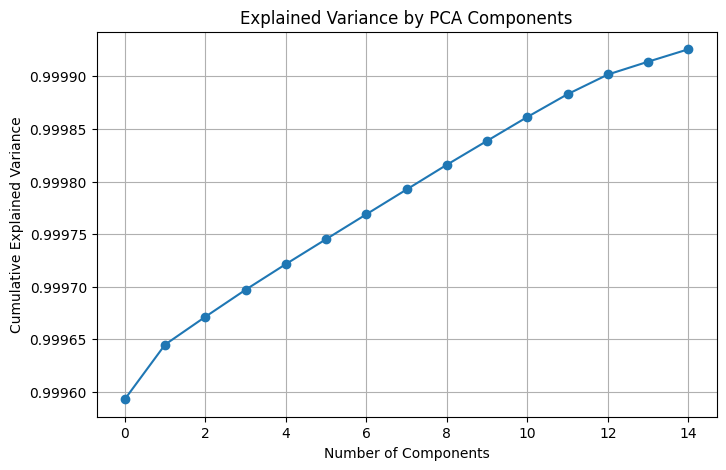

In [4]:
pca = PCA(n_components=15)
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)
X_test_pca = pca.transform(X_test)

plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by PCA Components')
plt.grid(True)
plt.show()

In [5]:
rf_estimators = [10,20,30,40 ,50,60]
rf_r2_scores_mse = []
rf_mse_scores_mse = []

print("Starting Random Forest training...")
for i in rf_estimators:
    rf = RandomForestRegressor(n_estimators=i, criterion="squared_error", 
                              random_state=42, n_jobs=-1)
    rf.fit(X_train_pca, y_train)
    y_pred = rf.predict(X_test_pca)
    rf_r2_scores_mse.append(r2_score(y_test, y_pred))
    rf_mse_scores_mse.append(mean_squared_error(y_test, y_pred))
    

Starting Random Forest training...


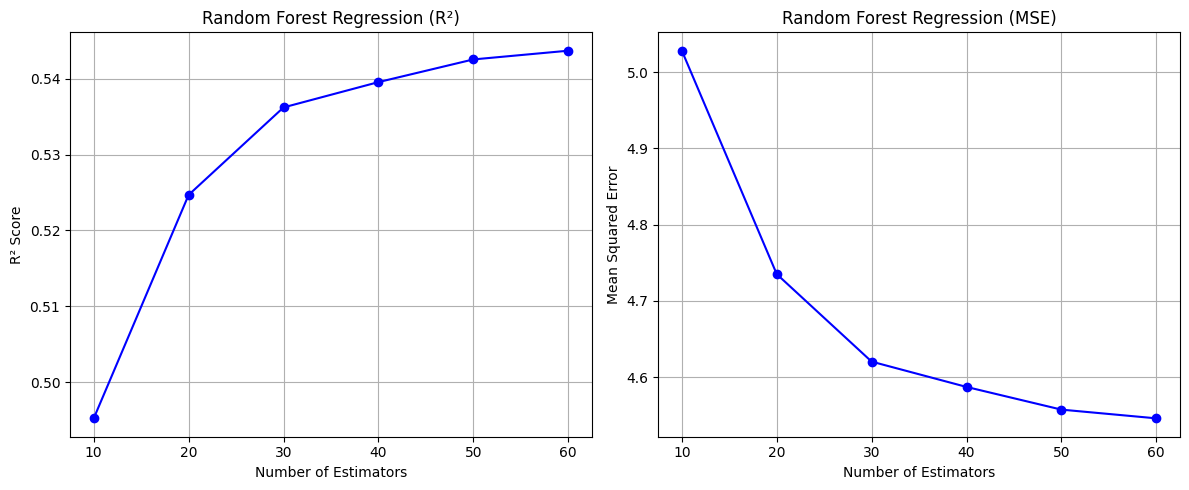

In [6]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(rf_estimators, rf_r2_scores_mse, marker='o', color='blue')
plt.xlabel("Number of Estimators")
plt.ylabel("R² Score")
plt.title("Random Forest Regression (R²)")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(rf_estimators, rf_mse_scores_mse, marker='o', color='blue')
plt.xlabel("Number of Estimators")
plt.ylabel("Mean Squared Error")
plt.title("Random Forest Regression (MSE)")
plt.grid(True)

plt.tight_layout()
plt.show()

In [9]:
from sklearn.ensemble import GradientBoostingRegressor
r2_scores = []
mse = []
mae = []
for i in range(1,15):
    gbr = GradientBoostingRegressor(max_depth=5, random_state=42)
    gbr.fit(X_train_pca[:, :i], y_train)
    y_pred = gbr.predict(X_test_pca[:, :i])
  
    r2_scores.append(r2_score(y_test, y_pred))
    mse.append(mean_squared_error(y_test, y_pred))
    mae.append(mean_absolute_error(y_test, y_pred))
    
    

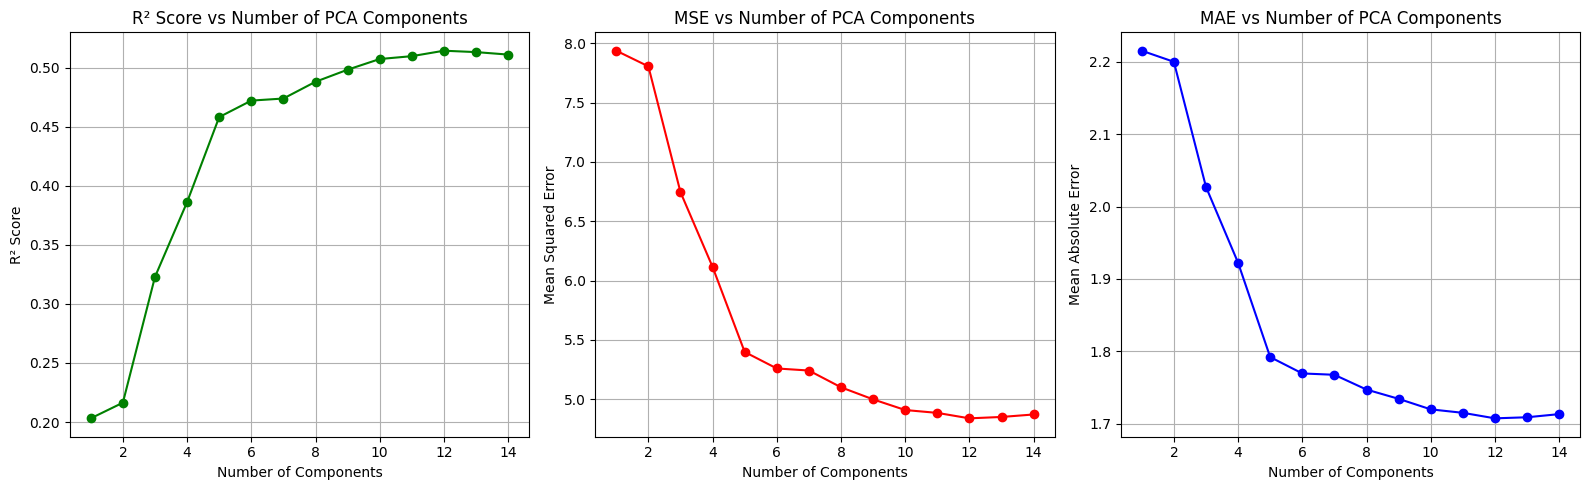

In [10]:
components = list(range(1, 15))

plt.figure(figsize=(16, 5))

# R² Score Plot
plt.subplot(1, 3, 1)
plt.plot(components, r2_scores, marker='o', color='green')
plt.title('R² Score vs Number of PCA Components')
plt.xlabel('Number of Components')
plt.ylabel('R² Score')
plt.grid(True)

# MSE Plot
plt.subplot(1, 3, 2)
plt.plot(components, mse, marker='o', color='red')
plt.title('MSE vs Number of PCA Components')
plt.xlabel('Number of Components')
plt.ylabel('Mean Squared Error')
plt.grid(True)

# MAE Plot
plt.subplot(1, 3, 3)
plt.plot(components, mae, marker='o', color='blue')
plt.title('MAE vs Number of PCA Components')
plt.xlabel('Number of Components')
plt.ylabel('Mean Absolute Error')
plt.grid(True)

plt.tight_layout()
plt.show()

In [11]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error

xgb = XGBRegressor(objective='reg:squarederror', random_state=42)

xgb_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0]
}

grid_xgb = GridSearchCV(
    xgb,
    xgb_param_grid,
    scoring='r2',
    cv=5,
    verbose=1,
    n_jobs=-1
)

grid_xgb.fit(X_train_pca, y_train)

print("Best Parameters (XGBoost):", grid_xgb.best_params_)

# Test on unseen data
y_pred_xgb = grid_xgb.predict(X_test_pca)
print("R² Score (XGBoost):", r2_score(y_test, y_pred_xgb))
print("MSE (XGBoost):", mean_squared_error(y_test, y_pred_xgb))

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Parameters (XGBoost): {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}
R² Score (XGBoost): 0.5545753588576412
MSE (XGBoost): 4.437250837525332
